<a href="https://colab.research.google.com/github/SanghunOh/study_machinglearning/blob/main/codes/sanghunoh/reports/Term_2_CNN_MPIE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Connect Drive

In [1]:
path_root = '/content/drive/MyDrive/datas/'

# 작업 경로 설정
import os
os.chdir(path_root)
!pwd

/content/drive/.shortcut-targets-by-id/1tHYgEz3lQF-LmtFPXRgMBDh4UN54qeAs/datas


In [2]:
# !unzip -o ./mpie_30_shuffle.zip -d ./mpie_30_shuffle

In [3]:
!ls

dataCh4_7.mat		 mpie_30_shuffle.zip
dataCh4_7.zip		 number_images
digitimages_binary.zip	 results_CNN_20222805113027.pickle
iris_shuffle.mat	 results_CNN_label_1_20222805113027.pickle
iris.zip		 results_CNN_label_1_20222805115011.pickle
matlab_iris_shuffle.mat  results_CNN_label_2_20222805113027.pickle
model.png		 results_CNN_label_2_20222805115011.pickle
mpie_30_shuffle		 results_CNN_label_4_20222805113027.pickle


###Load Dataset

In [4]:
path = path_root + 'mpie_30_shuffle/'

def loadDatasetFromCSV(_datafilename, _labelfilename, label_column):
  _feature_csv = pd.read_csv(path + _datafilename, dtype=np.float32, header=None) # image features of train data
  _feature_flatten = _feature_csv.values.flatten()
  _feature_reshape = np.reshape(_feature_flatten, (_feature_csv.shape[0], 32,-1))

  _label_csv = pd.read_csv(path + _labelfilename, dtype=np.float32, header=None) # labels of train data
  # print(f'_label_csv : {_label_csv.shape}')
  _label = _label_csv[label_column] # get label you want

  return _feature_reshape, _label

In [5]:
import pandas as pd
import numpy as np

# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', 0)
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', 0)

train_feature_reshape.shape, train_label.shape, validation_feature_reshape.shape, validation_label.shape

((18777, 32, 32), (18777,), (5086, 32, 32), (5086,))

In [6]:
np.unique(train_label)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.], dtype=float32)

In [7]:
import tensorflow as tf

def preprocessDataset(features_reshape, labels, batch_size=64, shuffle_buffer_size=100):
  _batch_size = batch_size
  _shuffle_buffer_size = shuffle_buffer_size

  _features = features_reshape
  _labels = labels
  _dataset_tensors = tf.data.Dataset.from_tensor_slices((_features, _labels))

  if _shuffle_buffer_size == None:
    _dataset_tensors = _dataset_tensors.batch(_batch_size)
  else :
    _dataset_tensors = _dataset_tensors.shuffle(_shuffle_buffer_size).batch(_batch_size)

  return _dataset_tensors

In [8]:
train_dataset = preprocessDataset(train_feature_reshape, train_label)
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [9]:
# train_dataset?

In [10]:
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

###Deep CNN with BatchNormalization

In [11]:
filters = 32
_filters = filters
_min_filters = 16
_hidden_layers = int(_filters / _min_filters)
for layer in range(_hidden_layers):
  print(f'decrease : {_filters}')
  _filters = int(_filters/2)
  if _filters < _min_filters:
    break

for layer in range(_hidden_layers):
  _filters = int(_filters*2)
  if _filters > filters:
    break
  print(f'increase : {_filters}')


decrease : 32
decrease : 16
increase : 16
increase : 32


In [12]:
from tensorflow.keras import layers

category_count = train_label.unique().shape[0]
def make_model(_class_cnt, filters=16, _padding='same', _kernel_initializer='he_normal'
      , _activation='relu', _optimizer='SGD', _kernel_size = (3,3), _strides = (1,1)
      , pool_type='max', batch_normal=True, _pool_size = (2,2), epochs=2, label_class=0):
    model = tf.keras.Sequential()

    _filters = filters
    _min_filters = 16
    _hidden_layers = int(_filters / _min_filters)

    for layer in range(_hidden_layers):
      model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size
                              , strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
      model.add(layers.Activation(_activation))
      if batch_normal:
        model.add(layers.BatchNormalization())
      if pool_type == 'max':
        model.add(layers.MaxPooling2D(pool_size = _pool_size, padding = _padding, strides=_strides))
      else :
        model.add(layers.AveragePooling2D(pool_size = _pool_size, padding = _padding, strides=_strides))

      _filters = int(_filters/2)
      if _filters < _min_filters:
        break

    # ?전 Layer에서 filter size 작아져 실행 않됨
    # for layer in range(_hidden_layers):
    #   _filters = int(_filters*2)
    #   if _filters > filters:
    #     break
    #   model.add(layers.Conv2D(input_shape = (32, 32, 1), filters = _filters, kernel_size = _kernel_size, strides = _strides, padding = _padding, kernel_initializer=_kernel_initializer))
    #   model.add(layers.Activation(_activation))
    #   if BatchNormal:
    #     model.add(layers.BatchNormalization())
    #   model.add(layers.MaxPooling2D(pool_size = _pool_size))

    # prior layer should be flattend to be connected to dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = _activation, kernel_initializer=_kernel_initializer))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(_class_cnt, activation = 'softmax', kernel_initializer=_kernel_initializer))

    # adam = optimizers.Adam(lr = 0.001)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = _optimizer, metrics = ['accuracy'])

    return model

In [13]:
model = make_model(_class_cnt=6, pool_type='max')    
# tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True) #layer_range=?, 

###callback function for fit time

In [14]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
TimeHistory()

### fit model

In [15]:
_epochs = 10
_batch_size = int(len(list(train_dataset)) / (len(list(train_dataset))/2))   # Just Check Model params quickly
# _batch_size = len(list(train_dataset))

def model_fit(_param, _train_dataset, _validation_dataset):
  tf.keras.backend.clear_session()

  model = make_model(**_param)
  time_callback = TimeHistory()
  history = model.fit(_train_dataset, epochs=_param['epochs'], validation_data=_validation_dataset, callbacks=[time_callback], steps_per_epoch=_batch_size)
  execution_time = sum(time_callback.times)
  return model, history, execution_time, _param

In [16]:
label_class = 0
# train
train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class)
class_cnt = len(np.unique(train_label))
# test
validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class)

train_dataset = preprocessDataset(train_feature_reshape, train_label)
validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

param = {'_class_cnt':class_cnt, 'epochs':2, 'label_class':label_class, '_kernel_initializer':None
         , '_activation':'sigmoid', 'batch_normal':False, '_optimizer':'RMSprop', 'filters':16 , '_padding':'valid'
         , 'pool_type':'max', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)}

model_fit(param, train_dataset, validation_dataset)

Epoch 1/2
2/2 [==============================] - 4s 2s/step - loss: 4.1691 - accuracy: 0.0078 - val_loss: 3.7357 - val_accuracy: 0.0391
Epoch 2/2
2/2 [==============================] - 2s 2s/step - loss: 3.9489 - accuracy: 0.0625 - val_loss: 3.6783 - val_accuracy: 0.0391


(<keras.engine.sequential.Sequential at 0x7f05b7623e90>,
 6.241080284118652,
 {'_activation': 'sigmoid',
  '_class_cnt': 30,
  '_kernel_initializer': None,
  '_kernel_size': (3, 3),
  '_optimizer': 'RMSprop',
  '_padding': 'valid',
  '_pool_size': (2, 2),
  '_strides': (1, 1),
  'batch_normal': False,
  'epochs': 2,
  'filters': 16,
  'label_class': 0,
  'pool_type': 'max'})

### fit with multi params
filters : larger than 16

In [17]:
param = {'_class_cnt':class_cnt, 'epochs':2, 'label_class':label_class, '_kernel_initializer':None
         , '_activation':'sigmoid', 'batch_normal':False, '_optimizer':'Nadam', 'filters':16 , '_padding':'same'
         , 'pool_type':'average', '_kernel_size': (3,3), '_strides': (1,1), '_pool_size': (2,2)}


In [18]:
# param 6
params = list()
param_key_list = list(param.keys())
epochs_list = [10, 50, 100]
_kernel_initializer_list = [None, 'glorot_uniform', 'he_normal']
_activation_list = ['sigmoid', 'relu']
_optimizer_list= ['Adam', 'Nadam']
batch_normal_list = [False, True]
filters_list = [16, 32]
_padding_list = ['same', 'valid']
_kernel_size_list = [(3,3), (5,5)]
_strides_list = [(1,1), (3,3)]
pool_type_list = ['average', 'max']

for filters in filters_list:
  for _padding in _padding_list:
    for _kernel_initializer in _kernel_initializer_list:
      for _activation in _activation_list:
        for _optimizer in _optimizer_list:
          for batch_normal in batch_normal_list:
            for epochs in epochs_list:
              for _kernel_size in _kernel_size_list:
                for _strides in _strides_list:
                  for pool_type in pool_type_list:
                    param_dict = dict()
                    param_dict['filters'] = filters
                    param_dict['_padding'] = _padding
                    param_dict['_kernel_initializer'] = _kernel_initializer
                    param_dict['_activation'] = _activation
                    param_dict['_optimizer'] = _optimizer
                    param_dict['batch_normal'] = batch_normal
                    param_dict['epochs'] = epochs
                    param_dict['_kernel_size'] = _kernel_size
                    param_dict['_strides'] = _strides
                    param_dict['pool_type'] = pool_type
                    # print(param_dict)
                    params.append(param_dict)
len(params)

2304

In [19]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y%d%m%H%M")
print("date and time =", dt_string)

import pickle

now = 2022-05-28 11:52:45.020314
date and time = 20222805115245


In [20]:
params = params[5:7]
label_classes = [1, 2, 4]
results_list = list()
for label_class in label_classes:
  train_feature_reshape, train_label = loadDatasetFromCSV('Traindata.csv', 'Trainlabel.csv', label_class)
  class_cnt = len(np.unique(train_label))
  # test
  validation_feature_reshape, validation_label = loadDatasetFromCSV('Testdata.csv', 'Testlabel.csv', label_class)

  train_dataset = preprocessDataset(train_feature_reshape, train_label)
  validation_dataset = preprocessDataset(validation_feature_reshape, validation_label, shuffle_buffer_size=None)

  results = list()          
  for idx, param in enumerate(params):
    param['_class_cnt'] = class_cnt
    param['label_class'] = label_class
    print('-'*5 +'[ '+ str(idx) + ' ]'+ '-'*5 + str(param))
    results.append(model_fit(param, train_dataset, validation_dataset))
  # save
  with open(f'results_CNN_label_{label_class}_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
  results_list = results_list + results


-----[ 0 ]-----{'filters': 16, '_padding': 'same', '_kernel_initializer': None, '_activation': 'sigmoid', '_optimizer': 'Adam', 'batch_normal': False, 'epochs': 10, '_kernel_size': (5, 5), '_strides': (1, 1), 'pool_type': 'max', '_class_cnt': 6, 'label_class': 1}
Epoch 1/10
2/2 [==============================] - 2s 2s/step - loss: 2.6262 - accuracy: 0.3047 - val_loss: 2.6229 - val_accuracy: 0.5387
Epoch 2/10
2/2 [==============================] - 2s 2s/step - loss: 2.4008 - accuracy: 0.5781 - val_loss: 2.5647 - val_accuracy: 0.5387
Epoch 3/10
2/2 [==============================] - 2s 2s/step - loss: 2.8510 - accuracy: 0.4609 - val_loss: 2.4898 - val_accuracy: 0.5387
Epoch 4/10
2/2 [==============================] - 2s 2s/step - loss: 2.1468 - accuracy: 0.5938 - val_loss: 2.4138 - val_accuracy: 0.5387
Epoch 5/10
2/2 [==============================] - 2s 2s/step - loss: 1.9565 - accuracy: 0.6484 - val_loss: 2.3413 - val_accuracy: 0.5387
Epoch 6/10
2/2 [==============================] - 2

In [21]:
# save
with open(f'results_CNN_{dt_string}.pickle', 'wb') as f:
    pickle.dump(results_list, f, pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://1fadabdc-3f59-418d-9ff9-c799a25d7533/assets
INFO:tensorflow:Assets written to: ram://5d2e62e4-0cc9-4def-bd9f-d5089102de2d/assets
INFO:tensorflow:Assets written to: ram://a2676b8b-2b5d-47d1-9850-592265561107/assets
INFO:tensorflow:Assets written to: ram://9b945f6b-d7ec-4de2-ac34-33f5ff83fd72/assets
INFO:tensorflow:Assets written to: ram://ff91d1b0-edfa-4d8b-a827-a2c842f7869e/assets
INFO:tensorflow:Assets written to: ram://87c7e1b2-ef71-459c-9355-38761ba2f005/assets


###describe model

In [22]:
len(results)

2

In [23]:
choose_index = 1
model = results[choose_index][0]

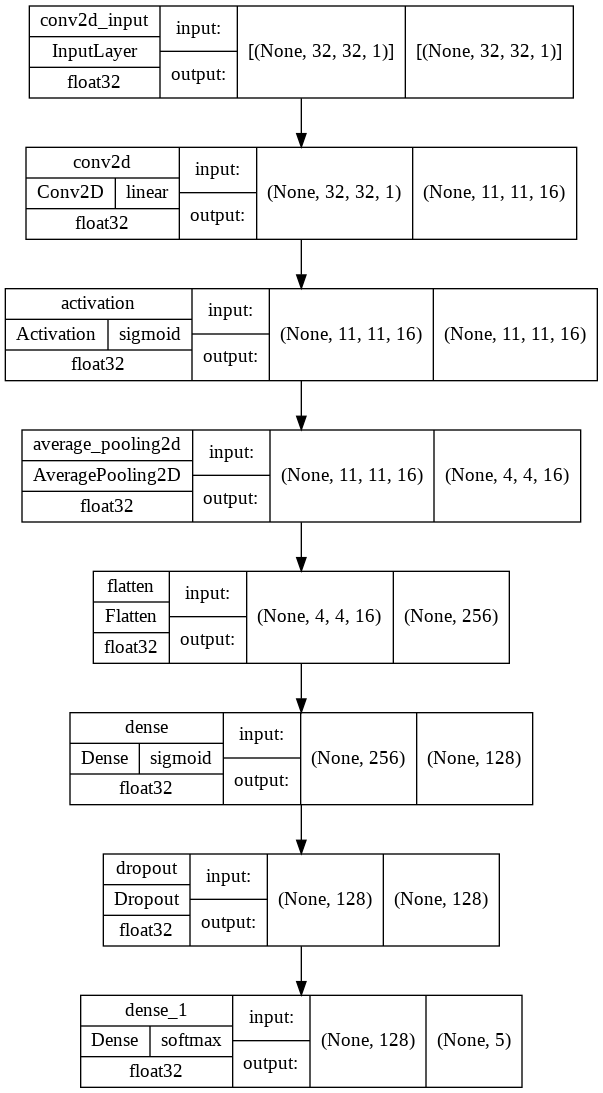

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, expand_nested=True, show_layer_activations=True) #layer_range=?, 

###drawing history model

In [25]:
history = results[choose_index][1]

In [26]:
history.history.keys(), history.params.keys()

(dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy']),
 dict_keys(['verbose', 'epochs', 'steps']))

In [27]:
history.history['accuracy'][-1]

0.3046875

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(_epochs)
# acc, list(epochs_range)

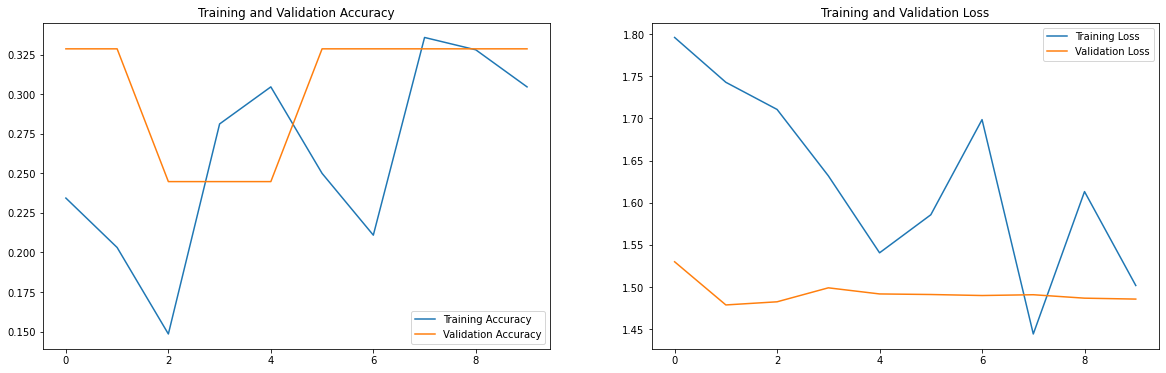

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### evaluate

In [30]:
model = results[choose_index][0]

In [31]:
model.evaluate(validation_dataset)

80/80 [==============================] - 1s 7ms/step - loss: 1.4857 - accuracy: 0.3287


[1.4857251644134521, 0.328745573759079]

In [32]:
predict_val = model.predict(validation_dataset).argmax(axis=1)
predict_val.shape, validation_label.shape

((5086,), (5086,))

In [33]:
predict_val[40:46], validation_label[40:46]

(array([1, 1, 1, 1, 1, 1]), 40    2.0
 41    1.0
 42    3.0
 43    2.0
 44    0.0
 45    3.0
 Name: 4, dtype: float32)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
# import seaborn as sns
# sns.heatmap(confusion_matrix(validation_label, predict_val), annot=True)

In [36]:
#Accuracy of the predicted values
print(classification_report(validation_label, predict_val)) 

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1245
         1.0       0.33      1.00      0.49      1672
         2.0       0.00      0.00      0.00      1315
         3.0       0.00      0.00      0.00       547
         4.0       0.00      0.00      0.00       307

    accuracy                           0.33      5086
   macro avg       0.07      0.20      0.10      5086
weighted avg       0.11      0.33      0.16      5086



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
import pandas as pd
# import warnings
# warnings.filterwarnings('always')

report = classification_report(validation_label, predict_val, output_dict=True)

pd.DataFrame(report).transpose()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0.0,0.000000,0.000000,0.000000,1245.000000
1.0,0.328746,1.000000,0.494821,1672.000000
2.0,0.000000,0.000000,0.000000,1315.000000
3.0,0.000000,0.000000,0.000000,547.000000
4.0,0.000000,0.000000,0.000000,307.000000
accuracy,0.328746,0.328746,0.328746,0.328746
macro avg,0.065749,0.200000,0.098964,5086.000000
weighted avg,0.108074,0.328746,0.162670,5086.000000
